In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

In [5]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

### loading the company's data

In [26]:
company = 'TSLA'
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

In [27]:
data = web.DataReader(company, 'yahoo', start, end)

In [28]:
# Prepare the data for the neural network
scalar = MinMaxScaler(feature_range=(0,1))
scaled_data = scalar.fit_transform(data['Adj Close'].values.reshape(-1,1))

In [29]:
prediction_days = 60
x_train = []
y_train = []
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [30]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train,epochs=25, batch_size=32 )



In [32]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()
test_data = web.DataReader(company,'yahoo',test_start, test_end)
actual_prices = test_data['Adj Close'].values

total_dataset = pd.concat((data['Adj Close'],test_data['Adj Close']), axis = 0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scalar.transform(model_inputs)

In [33]:
# making prediction on the test data
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x,0])

In [34]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [35]:
predicted_prices = model.predict(x_test)
predicted_prices = scalar.inverse_transform(predicted_prices)

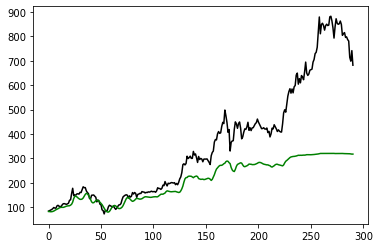

In [36]:
plt.plot(actual_prices, color = 'black')
plt.plot(predicted_prices, color = 'green')
plt.show()

In [25]:
# predicting the next day's data
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days: len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data  = np.reshape(real_data,(real_data.shape[0], real_data.shape[1],1))    
predictiontom = model.predict(real_data)

predictiontom = scalar.inverse_transform(predictiontom)